In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1377693, 828)
(1377693, 8)
validation
(248981, 828)
(248981, 8)
test
(138861, 828)
(138861, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/138 [..............................] - ETA: 3:03 - loss: 2.2703 - STD: 0.0547 - MAE: 0.2198

  4/138 [..............................] - ETA: 2s - loss: 2.1337 - STD: 0.0466 - MAE: 0.2174  

  7/138 [>.............................] - ETA: 2s - loss: 2.1111 - STD: 0.0493 - MAE: 0.2168

 10/138 [=>............................] - ETA: 2s - loss: 2.0982 - STD: 0.0483 - MAE: 0.2166

 13/138 [=>............................] - ETA: 2s - loss: 2.0882 - STD: 0.0441 - MAE: 0.2167

 16/138 [==>...........................] - ETA: 2s - loss: 2.0823 - STD: 0.0402 - MAE: 0.2168

 19/138 [===>..........................] - ETA: 2s - loss: 2.0782 - STD: 0.0387 - MAE: 0.2168

 22/138 [===>..........................] - ETA: 2s - loss: 2.0741 - STD: 0.0384 - MAE: 0.2168

 25/138 [====>.........................] - ETA: 2s - loss: 2.0707 - STD: 0.0379 - MAE: 0.2167

 28/138 [=====>........................] - ETA: 1s - loss: 2.0677 - STD: 0.0372 - MAE: 0.2167

 32/138 [=====>........................] - ETA: 1s - loss: 2.0631 - STD: 0.0367 - MAE: 0.2166

 35/138 [======>.......................] - ETA: 1s - loss: 2.0589 - STD: 0.0366 - MAE: 0.2165

 38/138 [=======>......................] - ETA: 1s - loss: 2.0537 - STD: 0.0364 - MAE: 0.2163

 41/138 [=======>......................] - ETA: 1s - loss: 2.0473 - STD: 0.0367 - MAE: 0.2161

 44/138 [========>.....................] - ETA: 1s - loss: 2.0396 - STD: 0.0375 - MAE: 0.2157

 47/138 [=========>....................] - ETA: 1s - loss: 2.0308 - STD: 0.0387 - MAE: 0.2153

 50/138 [=========>....................] - ETA: 2s - loss: 2.0214 - STD: 0.0403 - MAE: 0.2148

 53/138 [==========>...................] - ETA: 2s - loss: 2.0099 - STD: 0.0422 - MAE: 0.2141

 56/138 [===========>..................] - ETA: 2s - loss: 1.9970 - STD: 0.0443 - MAE: 0.2134

 60/138 [============>.................] - ETA: 2s - loss: 1.9785 - STD: 0.0473 - MAE: 0.2124

 63/138 [============>.................] - ETA: 2s - loss: 1.9644 - STD: 0.0498 - MAE: 0.2116

 66/138 [=============>................] - ETA: 2s - loss: 1.9505 - STD: 0.0523 - MAE: 0.2107

 69/138 [==============>...............] - ETA: 1s - loss: 1.9369 - STD: 0.0547 - MAE: 0.2099

 72/138 [==============>...............] - ETA: 1s - loss: 1.9233 - STD: 0.0571 - MAE: 0.2090

 75/138 [===============>..............] - ETA: 1s - loss: 1.9095 - STD: 0.0594 - MAE: 0.2081

 78/138 [===============>..............] - ETA: 1s - loss: 1.8961 - STD: 0.0617 - MAE: 0.2073

 81/138 [================>.............] - ETA: 1s - loss: 1.8828 - STD: 0.0638 - MAE: 0.2065

 85/138 [=================>............] - ETA: 1s - loss: 1.8656 - STD: 0.0666 - MAE: 0.2054

 88/138 [==================>...........] - ETA: 1s - loss: 1.8530 - STD: 0.0687 - MAE: 0.2045

 91/138 [==================>...........] - ETA: 1s - loss: 1.8405 - STD: 0.0707 - MAE: 0.2037

 95/138 [===================>..........] - ETA: 1s - loss: 1.8243 - STD: 0.0734 - MAE: 0.2026

 98/138 [====================>.........] - ETA: 0s - loss: 1.8126 - STD: 0.0754 - MAE: 0.2018

101/138 [====================>.........] - ETA: 0s - loss: 1.8012 - STD: 0.0774 - MAE: 0.2010

104/138 [=====================>........] - ETA: 0s - loss: 1.7902 - STD: 0.0794 - MAE: 0.2002

107/138 [======================>.......] - ETA: 0s - loss: 1.7796 - STD: 0.0813 - MAE: 0.1994

110/138 [======================>.......] - ETA: 0s - loss: 1.7696 - STD: 0.0832 - MAE: 0.1986

114/138 [=======================>......] - ETA: 0s - loss: 1.7567 - STD: 0.0855 - MAE: 0.1976

118/138 [========================>.....] - ETA: 0s - loss: 1.7444 - STD: 0.0878 - MAE: 0.1967

121/138 [=========================>....] - ETA: 0s - loss: 1.7356 - STD: 0.0894 - MAE: 0.1960

124/138 [=========================>....] - ETA: 0s - loss: 1.7269 - STD: 0.0910 - MAE: 0.1953

127/138 [==========================>...] - ETA: 0s - loss: 1.7188 - STD: 0.0926 - MAE: 0.1947

130/138 [===========================>..] - ETA: 0s - loss: 1.7109 - STD: 0.0940 - MAE: 0.1941

133/138 [===========================>..] - ETA: 0s - loss: 1.7033 - STD: 0.0954 - MAE: 0.1935

136/138 [============================>.] - ETA: 0s - loss: 1.6959 - STD: 0.0968 - MAE: 0.1929

138/138 [==============================] - 6s 31ms/step - loss: 1.6910 - STD: 0.0977 - MAE: 0.1925 - val_loss: 1.6626 - val_STD: 0.1594 - val_MAE: 0.1775


Epoch 2/10000


  1/138 [..............................] - ETA: 6s - loss: 1.3738 - STD: 0.1577 - MAE: 0.1674

  4/138 [..............................] - ETA: 2s - loss: 1.3483 - STD: 0.1590 - MAE: 0.1657

  7/138 [>.............................] - ETA: 2s - loss: 1.3457 - STD: 0.1599 - MAE: 0.1653

 11/138 [=>............................] - ETA: 2s - loss: 1.3464 - STD: 0.1605 - MAE: 0.1652

 14/138 [==>...........................] - ETA: 2s - loss: 1.3460 - STD: 0.1609 - MAE: 0.1650

 18/138 [==>...........................] - ETA: 2s - loss: 1.3439 - STD: 0.1610 - MAE: 0.1649

 21/138 [===>..........................] - ETA: 2s - loss: 1.3412 - STD: 0.1610 - MAE: 0.1647

 25/138 [====>.........................] - ETA: 1s - loss: 1.3379 - STD: 0.1616 - MAE: 0.1644

 29/138 [=====>........................] - ETA: 1s - loss: 1.3355 - STD: 0.1620 - MAE: 0.1641

 32/138 [=====>........................] - ETA: 1s - loss: 1.3331 - STD: 0.1624 - MAE: 0.1639

 35/138 [======>.......................] - ETA: 1s - loss: 1.3325 - STD: 0.1627 - MAE: 0.1638

 38/138 [=======>......................] - ETA: 1s - loss: 1.3320 - STD: 0.1628 - MAE: 0.1637

 41/138 [=======>......................] - ETA: 1s - loss: 1.3300 - STD: 0.1630 - MAE: 0.1636

 44/138 [========>.....................] - ETA: 1s - loss: 1.3276 - STD: 0.1633 - MAE: 0.1634

 47/138 [=========>....................] - ETA: 1s - loss: 1.3256 - STD: 0.1636 - MAE: 0.1632

 50/138 [=========>....................] - ETA: 1s - loss: 1.3242 - STD: 0.1640 - MAE: 0.1630

 53/138 [==========>...................] - ETA: 1s - loss: 1.3228 - STD: 0.1642 - MAE: 0.1628

 57/138 [===========>..................] - ETA: 1s - loss: 1.3199 - STD: 0.1645 - MAE: 0.1626

 61/138 [============>.................] - ETA: 1s - loss: 1.3175 - STD: 0.1649 - MAE: 0.1624

 65/138 [=============>................] - ETA: 1s - loss: 1.3152 - STD: 0.1652 - MAE: 0.1622

 69/138 [==============>...............] - ETA: 1s - loss: 1.3130 - STD: 0.1655 - MAE: 0.1620

 72/138 [==============>...............] - ETA: 1s - loss: 1.3113 - STD: 0.1657 - MAE: 0.1618

 75/138 [===============>..............] - ETA: 1s - loss: 1.3098 - STD: 0.1659 - MAE: 0.1617

 78/138 [===============>..............] - ETA: 1s - loss: 1.3084 - STD: 0.1662 - MAE: 0.1615

 81/138 [================>.............] - ETA: 0s - loss: 1.3074 - STD: 0.1664 - MAE: 0.1614

 84/138 [=================>............] - ETA: 0s - loss: 1.3056 - STD: 0.1666 - MAE: 0.1613

 87/138 [=================>............] - ETA: 0s - loss: 1.3044 - STD: 0.1668 - MAE: 0.1611

 91/138 [==================>...........] - ETA: 0s - loss: 1.3021 - STD: 0.1670 - MAE: 0.1609

 95/138 [===================>..........] - ETA: 0s - loss: 1.3000 - STD: 0.1674 - MAE: 0.1607

 98/138 [====================>.........] - ETA: 0s - loss: 1.2989 - STD: 0.1676 - MAE: 0.1606

101/138 [====================>.........] - ETA: 0s - loss: 1.2976 - STD: 0.1678 - MAE: 0.1605

104/138 [=====================>........] - ETA: 0s - loss: 1.2964 - STD: 0.1680 - MAE: 0.1604

107/138 [======================>.......] - ETA: 0s - loss: 1.2950 - STD: 0.1682 - MAE: 0.1602

110/138 [======================>.......] - ETA: 0s - loss: 1.2936 - STD: 0.1685 - MAE: 0.1601

113/138 [=======================>......] - ETA: 0s - loss: 1.2921 - STD: 0.1687 - MAE: 0.1599

116/138 [========================>.....] - ETA: 0s - loss: 1.2905 - STD: 0.1688 - MAE: 0.1598

119/138 [========================>.....] - ETA: 0s - loss: 1.2890 - STD: 0.1690 - MAE: 0.1597

122/138 [=========================>....] - ETA: 0s - loss: 1.2876 - STD: 0.1692 - MAE: 0.1595

126/138 [==========================>...] - ETA: 0s - loss: 1.2854 - STD: 0.1695 - MAE: 0.1593

130/138 [===========================>..] - ETA: 0s - loss: 1.2833 - STD: 0.1698 - MAE: 0.1591

133/138 [===========================>..] - ETA: 0s - loss: 1.2816 - STD: 0.1700 - MAE: 0.1590

137/138 [============================>.] - ETA: 0s - loss: 1.2796 - STD: 0.1703 - MAE: 0.1588

138/138 [==============================] - 3s 20ms/step - loss: 1.2790 - STD: 0.1704 - MAE: 0.1587 - val_loss: 1.5976 - val_STD: 0.1773 - val_MAE: 0.1670


Epoch 3/10000


  1/138 [..............................] - ETA: 7s - loss: 1.2027 - STD: 0.1791 - MAE: 0.1521

  4/138 [..............................] - ETA: 2s - loss: 1.2032 - STD: 0.1797 - MAE: 0.1519

  7/138 [>.............................] - ETA: 2s - loss: 1.1992 - STD: 0.1799 - MAE: 0.1517

 10/138 [=>............................] - ETA: 2s - loss: 1.2004 - STD: 0.1804 - MAE: 0.1516

 13/138 [=>............................] - ETA: 2s - loss: 1.1987 - STD: 0.1806 - MAE: 0.1515

 16/138 [==>...........................] - ETA: 2s - loss: 1.1985 - STD: 0.1807 - MAE: 0.1515

 20/138 [===>..........................] - ETA: 2s - loss: 1.1996 - STD: 0.1807 - MAE: 0.1514

 23/138 [====>.........................] - ETA: 2s - loss: 1.1977 - STD: 0.1808 - MAE: 0.1513

 27/138 [====>.........................] - ETA: 2s - loss: 1.1965 - STD: 0.1810 - MAE: 0.1512

 30/138 [=====>........................] - ETA: 2s - loss: 1.1984 - STD: 0.1813 - MAE: 0.1512

 33/138 [======>.......................] - ETA: 1s - loss: 1.2010 - STD: 0.1815 - MAE: 0.1512

 36/138 [======>.......................] - ETA: 1s - loss: 1.2039 - STD: 0.1816 - MAE: 0.1513

 39/138 [=======>......................] - ETA: 1s - loss: 1.2036 - STD: 0.1816 - MAE: 0.1513

 42/138 [========>.....................] - ETA: 1s - loss: 1.2027 - STD: 0.1815 - MAE: 0.1513

 46/138 [=========>....................] - ETA: 1s - loss: 1.2013 - STD: 0.1816 - MAE: 0.1512

 50/138 [=========>....................] - ETA: 1s - loss: 1.2008 - STD: 0.1819 - MAE: 0.1510

 53/138 [==========>...................] - ETA: 1s - loss: 1.1999 - STD: 0.1820 - MAE: 0.1510

 56/138 [===========>..................] - ETA: 1s - loss: 1.1986 - STD: 0.1821 - MAE: 0.1509

 59/138 [===========>..................] - ETA: 1s - loss: 1.1977 - STD: 0.1822 - MAE: 0.1508

 63/138 [============>.................] - ETA: 1s - loss: 1.1966 - STD: 0.1824 - MAE: 0.1507

 67/138 [=============>................] - ETA: 1s - loss: 1.1951 - STD: 0.1826 - MAE: 0.1505

 71/138 [==============>...............] - ETA: 1s - loss: 1.1944 - STD: 0.1827 - MAE: 0.1504

 74/138 [===============>..............] - ETA: 1s - loss: 1.1931 - STD: 0.1828 - MAE: 0.1503

 77/138 [===============>..............] - ETA: 1s - loss: 1.1924 - STD: 0.1829 - MAE: 0.1503

 80/138 [================>.............] - ETA: 1s - loss: 1.1919 - STD: 0.1831 - MAE: 0.1502

 83/138 [=================>............] - ETA: 0s - loss: 1.1910 - STD: 0.1832 - MAE: 0.1501

 86/138 [=================>............] - ETA: 0s - loss: 1.1897 - STD: 0.1834 - MAE: 0.1500

 89/138 [==================>...........] - ETA: 0s - loss: 1.1884 - STD: 0.1834 - MAE: 0.1499

 93/138 [===================>..........] - ETA: 0s - loss: 1.1868 - STD: 0.1836 - MAE: 0.1498

 96/138 [===================>..........] - ETA: 0s - loss: 1.1856 - STD: 0.1837 - MAE: 0.1496

 99/138 [====================>.........] - ETA: 0s - loss: 1.1843 - STD: 0.1839 - MAE: 0.1495

102/138 [=====================>........] - ETA: 0s - loss: 1.1833 - STD: 0.1840 - MAE: 0.1494

105/138 [=====================>........] - ETA: 0s - loss: 1.1825 - STD: 0.1841 - MAE: 0.1494

108/138 [======================>.......] - ETA: 0s - loss: 1.1820 - STD: 0.1842 - MAE: 0.1493

111/138 [=======================>......] - ETA: 0s - loss: 1.1811 - STD: 0.1843 - MAE: 0.1492

115/138 [========================>.....] - ETA: 0s - loss: 1.1798 - STD: 0.1845 - MAE: 0.1491

118/138 [========================>.....] - ETA: 0s - loss: 1.1787 - STD: 0.1846 - MAE: 0.1490

121/138 [=========================>....] - ETA: 0s - loss: 1.1776 - STD: 0.1847 - MAE: 0.1489

124/138 [=========================>....] - ETA: 0s - loss: 1.1763 - STD: 0.1848 - MAE: 0.1488

127/138 [==========================>...] - ETA: 0s - loss: 1.1751 - STD: 0.1849 - MAE: 0.1487

130/138 [===========================>..] - ETA: 0s - loss: 1.1739 - STD: 0.1851 - MAE: 0.1486

133/138 [===========================>..] - ETA: 0s - loss: 1.1730 - STD: 0.1852 - MAE: 0.1485

137/138 [============================>.] - ETA: 0s - loss: 1.1717 - STD: 0.1853 - MAE: 0.1484

138/138 [==============================] - 3s 21ms/step - loss: 1.1716 - STD: 0.1854 - MAE: 0.1483 - val_loss: 1.5476 - val_STD: 0.1860 - val_MAE: 0.1597


Epoch 4/10000


  1/138 [..............................] - ETA: 6s - loss: 1.1896 - STD: 0.1920 - MAE: 0.1471

  4/138 [..............................] - ETA: 2s - loss: 1.1420 - STD: 0.1922 - MAE: 0.1444

  8/138 [>.............................] - ETA: 2s - loss: 1.1355 - STD: 0.1918 - MAE: 0.1442

 11/138 [=>............................] - ETA: 2s - loss: 1.1321 - STD: 0.1916 - MAE: 0.1441

 14/138 [==>...........................] - ETA: 2s - loss: 1.1289 - STD: 0.1914 - MAE: 0.1440

 18/138 [==>...........................] - ETA: 2s - loss: 1.1256 - STD: 0.1913 - MAE: 0.1438

 22/138 [===>..........................] - ETA: 2s - loss: 1.1223 - STD: 0.1915 - MAE: 0.1436

 25/138 [====>.........................] - ETA: 1s - loss: 1.1201 - STD: 0.1917 - MAE: 0.1434

 28/138 [=====>........................] - ETA: 1s - loss: 1.1191 - STD: 0.1920 - MAE: 0.1432

 31/138 [=====>........................] - ETA: 1s - loss: 1.1178 - STD: 0.1920 - MAE: 0.1432

 34/138 [======>.......................] - ETA: 1s - loss: 1.1165 - STD: 0.1920 - MAE: 0.1431

 37/138 [=======>......................] - ETA: 1s - loss: 1.1153 - STD: 0.1922 - MAE: 0.1430

 40/138 [=======>......................] - ETA: 1s - loss: 1.1188 - STD: 0.1923 - MAE: 0.1431

 43/138 [========>.....................] - ETA: 1s - loss: 1.1189 - STD: 0.1925 - MAE: 0.1430

 46/138 [=========>....................] - ETA: 1s - loss: 1.1181 - STD: 0.1927 - MAE: 0.1429

 49/138 [=========>....................] - ETA: 1s - loss: 1.1170 - STD: 0.1928 - MAE: 0.1428

 52/138 [==========>...................] - ETA: 1s - loss: 1.1163 - STD: 0.1927 - MAE: 0.1428

 55/138 [==========>...................] - ETA: 1s - loss: 1.1147 - STD: 0.1928 - MAE: 0.1427

 58/138 [===========>..................] - ETA: 1s - loss: 1.1137 - STD: 0.1929 - MAE: 0.1426

 61/138 [============>.................] - ETA: 1s - loss: 1.1125 - STD: 0.1930 - MAE: 0.1425

 64/138 [============>.................] - ETA: 1s - loss: 1.1116 - STD: 0.1931 - MAE: 0.1424

 67/138 [=============>................] - ETA: 1s - loss: 1.1112 - STD: 0.1932 - MAE: 0.1424

 70/138 [==============>...............] - ETA: 1s - loss: 1.1106 - STD: 0.1933 - MAE: 0.1423

 73/138 [==============>...............] - ETA: 1s - loss: 1.1103 - STD: 0.1934 - MAE: 0.1422

 76/138 [===============>..............] - ETA: 1s - loss: 1.1095 - STD: 0.1935 - MAE: 0.1422

 79/138 [================>.............] - ETA: 1s - loss: 1.1094 - STD: 0.1936 - MAE: 0.1421

 82/138 [================>.............] - ETA: 0s - loss: 1.1090 - STD: 0.1937 - MAE: 0.1421

 85/138 [=================>............] - ETA: 0s - loss: 1.1083 - STD: 0.1938 - MAE: 0.1420

 88/138 [==================>...........] - ETA: 0s - loss: 1.1078 - STD: 0.1939 - MAE: 0.1419

 91/138 [==================>...........] - ETA: 0s - loss: 1.1071 - STD: 0.1940 - MAE: 0.1419

 94/138 [===================>..........] - ETA: 0s - loss: 1.1064 - STD: 0.1940 - MAE: 0.1418

 97/138 [====================>.........] - ETA: 0s - loss: 1.1055 - STD: 0.1941 - MAE: 0.1417

100/138 [====================>.........] - ETA: 0s - loss: 1.1046 - STD: 0.1942 - MAE: 0.1417

103/138 [=====================>........] - ETA: 0s - loss: 1.1040 - STD: 0.1943 - MAE: 0.1416

106/138 [======================>.......] - ETA: 0s - loss: 1.1038 - STD: 0.1943 - MAE: 0.1416

109/138 [======================>.......] - ETA: 0s - loss: 1.1031 - STD: 0.1944 - MAE: 0.1415

112/138 [=======================>......] - ETA: 0s - loss: 1.1027 - STD: 0.1946 - MAE: 0.1414

115/138 [========================>.....] - ETA: 0s - loss: 1.1020 - STD: 0.1947 - MAE: 0.1413

118/138 [========================>.....] - ETA: 0s - loss: 1.1011 - STD: 0.1948 - MAE: 0.1412

121/138 [=========================>....] - ETA: 0s - loss: 1.1004 - STD: 0.1948 - MAE: 0.1412

124/138 [=========================>....] - ETA: 0s - loss: 1.0994 - STD: 0.1949 - MAE: 0.1411

127/138 [==========================>...] - ETA: 0s - loss: 1.0987 - STD: 0.1951 - MAE: 0.1410

130/138 [===========================>..] - ETA: 0s - loss: 1.0978 - STD: 0.1951 - MAE: 0.1409

133/138 [===========================>..] - ETA: 0s - loss: 1.0971 - STD: 0.1952 - MAE: 0.1408

136/138 [============================>.] - ETA: 0s - loss: 1.0969 - STD: 0.1953 - MAE: 0.1408

138/138 [==============================] - 3s 21ms/step - loss: 1.0962 - STD: 0.1954 - MAE: 0.1407 - val_loss: 1.5291 - val_STD: 0.1948 - val_MAE: 0.1543


Epoch 5/10000


  1/138 [..............................] - ETA: 5s - loss: 1.0741 - STD: 0.1995 - MAE: 0.1381

  4/138 [..............................] - ETA: 2s - loss: 1.0626 - STD: 0.1995 - MAE: 0.1375

  7/138 [>.............................] - ETA: 2s - loss: 1.0647 - STD: 0.1996 - MAE: 0.1374

 10/138 [=>............................] - ETA: 2s - loss: 1.0765 - STD: 0.1996 - MAE: 0.1380

 13/138 [=>............................] - ETA: 2s - loss: 1.0740 - STD: 0.1997 - MAE: 0.1378

 16/138 [==>...........................] - ETA: 2s - loss: 1.0694 - STD: 0.1999 - MAE: 0.1375

 19/138 [===>..........................] - ETA: 2s - loss: 1.0667 - STD: 0.1999 - MAE: 0.1374

 22/138 [===>..........................] - ETA: 2s - loss: 1.0638 - STD: 0.1999 - MAE: 0.1372

 25/138 [====>.........................] - ETA: 2s - loss: 1.0616 - STD: 0.2000 - MAE: 0.1371

 28/138 [=====>........................] - ETA: 2s - loss: 1.0610 - STD: 0.2000 - MAE: 0.1370

 31/138 [=====>........................] - ETA: 1s - loss: 1.0592 - STD: 0.2001 - MAE: 0.1369

 35/138 [======>.......................] - ETA: 1s - loss: 1.0587 - STD: 0.2002 - MAE: 0.1368

 38/138 [=======>......................] - ETA: 1s - loss: 1.0574 - STD: 0.2004 - MAE: 0.1367

 42/138 [========>.....................] - ETA: 1s - loss: 1.0572 - STD: 0.2004 - MAE: 0.1366

 45/138 [========>.....................] - ETA: 1s - loss: 1.0610 - STD: 0.2005 - MAE: 0.1367

 48/138 [=========>....................] - ETA: 1s - loss: 1.0617 - STD: 0.2008 - MAE: 0.1367

 52/138 [==========>...................] - ETA: 1s - loss: 1.0615 - STD: 0.2008 - MAE: 0.1367

 56/138 [===========>..................] - ETA: 1s - loss: 1.0606 - STD: 0.2008 - MAE: 0.1366

 60/138 [============>.................] - ETA: 1s - loss: 1.0592 - STD: 0.2009 - MAE: 0.1365

 63/138 [============>.................] - ETA: 1s - loss: 1.0585 - STD: 0.2010 - MAE: 0.1364

 66/138 [=============>................] - ETA: 1s - loss: 1.0579 - STD: 0.2010 - MAE: 0.1364

 69/138 [==============>...............] - ETA: 1s - loss: 1.0573 - STD: 0.2010 - MAE: 0.1364

 72/138 [==============>...............] - ETA: 1s - loss: 1.0564 - STD: 0.2010 - MAE: 0.1363

 75/138 [===============>..............] - ETA: 1s - loss: 1.0554 - STD: 0.2010 - MAE: 0.1362

 78/138 [===============>..............] - ETA: 1s - loss: 1.0544 - STD: 0.2011 - MAE: 0.1361

 81/138 [================>.............] - ETA: 1s - loss: 1.0536 - STD: 0.2012 - MAE: 0.1361

 84/138 [=================>............] - ETA: 0s - loss: 1.0527 - STD: 0.2013 - MAE: 0.1360

 87/138 [=================>............] - ETA: 0s - loss: 1.0520 - STD: 0.2014 - MAE: 0.1359

 90/138 [==================>...........] - ETA: 0s - loss: 1.0508 - STD: 0.2015 - MAE: 0.1358

 94/138 [===================>..........] - ETA: 0s - loss: 1.0505 - STD: 0.2016 - MAE: 0.1357

 97/138 [====================>.........] - ETA: 0s - loss: 1.0503 - STD: 0.2017 - MAE: 0.1356

100/138 [====================>.........] - ETA: 0s - loss: 1.0499 - STD: 0.2018 - MAE: 0.1356

103/138 [=====================>........] - ETA: 0s - loss: 1.0496 - STD: 0.2019 - MAE: 0.1355

106/138 [======================>.......] - ETA: 0s - loss: 1.0488 - STD: 0.2020 - MAE: 0.1355

109/138 [======================>.......] - ETA: 0s - loss: 1.0484 - STD: 0.2020 - MAE: 0.1354

112/138 [=======================>......] - ETA: 0s - loss: 1.0479 - STD: 0.2021 - MAE: 0.1354

115/138 [========================>.....] - ETA: 0s - loss: 1.0475 - STD: 0.2021 - MAE: 0.1353

118/138 [========================>.....] - ETA: 0s - loss: 1.0467 - STD: 0.2022 - MAE: 0.1353

121/138 [=========================>....] - ETA: 0s - loss: 1.0461 - STD: 0.2022 - MAE: 0.1352

124/138 [=========================>....] - ETA: 0s - loss: 1.0457 - STD: 0.2023 - MAE: 0.1352

127/138 [==========================>...] - ETA: 0s - loss: 1.0455 - STD: 0.2024 - MAE: 0.1351

130/138 [===========================>..] - ETA: 0s - loss: 1.0448 - STD: 0.2025 - MAE: 0.1350

133/138 [===========================>..] - ETA: 0s - loss: 1.0446 - STD: 0.2026 - MAE: 0.1350

136/138 [============================>.] - ETA: 0s - loss: 1.0440 - STD: 0.2026 - MAE: 0.1349

138/138 [==============================] - 3s 21ms/step - loss: 1.0437 - STD: 0.2027 - MAE: 0.1349 - val_loss: 1.5364 - val_STD: 0.1986 - val_MAE: 0.1516


Epoch 6/10000


  1/138 [..............................] - ETA: 6s - loss: 1.0163 - STD: 0.2037 - MAE: 0.1329

  4/138 [..............................] - ETA: 2s - loss: 1.0102 - STD: 0.2050 - MAE: 0.1321

  7/138 [>.............................] - ETA: 2s - loss: 1.0174 - STD: 0.2050 - MAE: 0.1325

 11/138 [=>............................] - ETA: 2s - loss: 1.0177 - STD: 0.2056 - MAE: 0.1324

 14/138 [==>...........................] - ETA: 2s - loss: 1.0170 - STD: 0.2060 - MAE: 0.1321

 17/138 [==>...........................] - ETA: 2s - loss: 1.0189 - STD: 0.2061 - MAE: 0.1322

 20/138 [===>..........................] - ETA: 2s - loss: 1.0203 - STD: 0.2061 - MAE: 0.1323

 24/138 [====>.........................] - ETA: 2s - loss: 1.0190 - STD: 0.2060 - MAE: 0.1322

 27/138 [====>.........................] - ETA: 1s - loss: 1.0181 - STD: 0.2060 - MAE: 0.1322

 30/138 [=====>........................] - ETA: 1s - loss: 1.0173 - STD: 0.2061 - MAE: 0.1321

 33/138 [======>.......................] - ETA: 1s - loss: 1.0161 - STD: 0.2062 - MAE: 0.1320

 36/138 [======>.......................] - ETA: 1s - loss: 1.0152 - STD: 0.2062 - MAE: 0.1319

 39/138 [=======>......................] - ETA: 1s - loss: 1.0159 - STD: 0.2062 - MAE: 0.1319

 42/138 [========>.....................] - ETA: 1s - loss: 1.0147 - STD: 0.2063 - MAE: 0.1319

 45/138 [========>.....................] - ETA: 1s - loss: 1.0136 - STD: 0.2064 - MAE: 0.1318

 48/138 [=========>....................] - ETA: 1s - loss: 1.0124 - STD: 0.2065 - MAE: 0.1317

 51/138 [==========>...................] - ETA: 1s - loss: 1.0121 - STD: 0.2065 - MAE: 0.1316

 54/138 [==========>...................] - ETA: 1s - loss: 1.0117 - STD: 0.2065 - MAE: 0.1316

 57/138 [===========>..................] - ETA: 1s - loss: 1.0145 - STD: 0.2067 - MAE: 0.1317

 61/138 [============>.................] - ETA: 1s - loss: 1.0159 - STD: 0.2068 - MAE: 0.1317

 65/138 [=============>................] - ETA: 1s - loss: 1.0165 - STD: 0.2070 - MAE: 0.1317

 68/138 [=============>................] - ETA: 1s - loss: 1.0164 - STD: 0.2070 - MAE: 0.1317

 72/138 [==============>...............] - ETA: 1s - loss: 1.0163 - STD: 0.2071 - MAE: 0.1316

 75/138 [===============>..............] - ETA: 1s - loss: 1.0159 - STD: 0.2071 - MAE: 0.1316

 78/138 [===============>..............] - ETA: 1s - loss: 1.0154 - STD: 0.2071 - MAE: 0.1316

 82/138 [================>.............] - ETA: 0s - loss: 1.0142 - STD: 0.2071 - MAE: 0.1315

 85/138 [=================>............] - ETA: 0s - loss: 1.0136 - STD: 0.2072 - MAE: 0.1314

 88/138 [==================>...........] - ETA: 0s - loss: 1.0127 - STD: 0.2072 - MAE: 0.1313

 91/138 [==================>...........] - ETA: 0s - loss: 1.0117 - STD: 0.2072 - MAE: 0.1313

 94/138 [===================>..........] - ETA: 0s - loss: 1.0110 - STD: 0.2073 - MAE: 0.1312

 97/138 [====================>.........] - ETA: 0s - loss: 1.0102 - STD: 0.2074 - MAE: 0.1311

100/138 [====================>.........] - ETA: 0s - loss: 1.0094 - STD: 0.2074 - MAE: 0.1311

103/138 [=====================>........] - ETA: 0s - loss: 1.0085 - STD: 0.2075 - MAE: 0.1310

106/138 [======================>.......] - ETA: 0s - loss: 1.0078 - STD: 0.2075 - MAE: 0.1309

109/138 [======================>.......] - ETA: 0s - loss: 1.0069 - STD: 0.2076 - MAE: 0.1308

112/138 [=======================>......] - ETA: 0s - loss: 1.0061 - STD: 0.2076 - MAE: 0.1308

115/138 [========================>.....] - ETA: 0s - loss: 1.0053 - STD: 0.2077 - MAE: 0.1307

118/138 [========================>.....] - ETA: 0s - loss: 1.0046 - STD: 0.2078 - MAE: 0.1306

121/138 [=========================>....] - ETA: 0s - loss: 1.0044 - STD: 0.2078 - MAE: 0.1306

125/138 [==========================>...] - ETA: 0s - loss: 1.0041 - STD: 0.2079 - MAE: 0.1305

128/138 [==========================>...] - ETA: 0s - loss: 1.0043 - STD: 0.2080 - MAE: 0.1305

131/138 [===========================>..] - ETA: 0s - loss: 1.0040 - STD: 0.2081 - MAE: 0.1305

134/138 [============================>.] - ETA: 0s - loss: 1.0038 - STD: 0.2081 - MAE: 0.1304

138/138 [==============================] - ETA: 0s - loss: 1.0037 - STD: 0.2082 - MAE: 0.1304

138/138 [==============================] - 3s 21ms/step - loss: 1.0037 - STD: 0.2082 - MAE: 0.1304 - val_loss: 1.5950 - val_STD: 0.2078 - val_MAE: 0.1498


Epoch 7/10000


  1/138 [..............................] - ETA: 6s - loss: 0.9931 - STD: 0.2113 - MAE: 0.1289

  4/138 [..............................] - ETA: 2s - loss: 0.9862 - STD: 0.2104 - MAE: 0.1285

  7/138 [>.............................] - ETA: 2s - loss: 0.9835 - STD: 0.2100 - MAE: 0.1286

 10/138 [=>............................] - ETA: 2s - loss: 0.9841 - STD: 0.2102 - MAE: 0.1286

 13/138 [=>............................] - ETA: 2s - loss: 0.9813 - STD: 0.2102 - MAE: 0.1284

 16/138 [==>...........................] - ETA: 2s - loss: 0.9793 - STD: 0.2103 - MAE: 0.1282

 19/138 [===>..........................] - ETA: 2s - loss: 0.9816 - STD: 0.2103 - MAE: 0.1283

 22/138 [===>..........................] - ETA: 2s - loss: 0.9801 - STD: 0.2105 - MAE: 0.1282

 26/138 [====>.........................] - ETA: 2s - loss: 0.9780 - STD: 0.2107 - MAE: 0.1280

 29/138 [=====>........................] - ETA: 1s - loss: 0.9775 - STD: 0.2107 - MAE: 0.1279

 32/138 [=====>........................] - ETA: 1s - loss: 0.9752 - STD: 0.2108 - MAE: 0.1278

 35/138 [======>.......................] - ETA: 1s - loss: 0.9758 - STD: 0.2109 - MAE: 0.1278

 38/138 [=======>......................] - ETA: 1s - loss: 0.9801 - STD: 0.2110 - MAE: 0.1280

 41/138 [=======>......................] - ETA: 1s - loss: 0.9800 - STD: 0.2111 - MAE: 0.1279

 44/138 [========>.....................] - ETA: 1s - loss: 0.9803 - STD: 0.2111 - MAE: 0.1279

 47/138 [=========>....................] - ETA: 1s - loss: 0.9806 - STD: 0.2112 - MAE: 0.1279

 50/138 [=========>....................] - ETA: 1s - loss: 0.9797 - STD: 0.2112 - MAE: 0.1278

 53/138 [==========>...................] - ETA: 1s - loss: 0.9798 - STD: 0.2112 - MAE: 0.1278

 56/138 [===========>..................] - ETA: 1s - loss: 0.9792 - STD: 0.2113 - MAE: 0.1278

 59/138 [===========>..................] - ETA: 1s - loss: 0.9776 - STD: 0.2113 - MAE: 0.1277

 62/138 [============>.................] - ETA: 1s - loss: 0.9768 - STD: 0.2113 - MAE: 0.1276

 65/138 [=============>................] - ETA: 1s - loss: 0.9765 - STD: 0.2114 - MAE: 0.1275

 68/138 [=============>................] - ETA: 1s - loss: 0.9761 - STD: 0.2115 - MAE: 0.1275

 72/138 [==============>...............] - ETA: 1s - loss: 0.9748 - STD: 0.2115 - MAE: 0.1274

 75/138 [===============>..............] - ETA: 1s - loss: 0.9742 - STD: 0.2116 - MAE: 0.1273

 78/138 [===============>..............] - ETA: 1s - loss: 0.9739 - STD: 0.2117 - MAE: 0.1273

 81/138 [================>.............] - ETA: 0s - loss: 0.9733 - STD: 0.2117 - MAE: 0.1272

 85/138 [=================>............] - ETA: 0s - loss: 0.9724 - STD: 0.2117 - MAE: 0.1272

 88/138 [==================>...........] - ETA: 0s - loss: 0.9718 - STD: 0.2118 - MAE: 0.1271

 91/138 [==================>...........] - ETA: 0s - loss: 0.9713 - STD: 0.2118 - MAE: 0.1271

 95/138 [===================>..........] - ETA: 0s - loss: 0.9704 - STD: 0.2119 - MAE: 0.1270

 98/138 [====================>.........] - ETA: 0s - loss: 0.9698 - STD: 0.2120 - MAE: 0.1269

101/138 [====================>.........] - ETA: 0s - loss: 0.9698 - STD: 0.2121 - MAE: 0.1269

105/138 [=====================>........] - ETA: 0s - loss: 0.9699 - STD: 0.2122 - MAE: 0.1269

109/138 [======================>.......] - ETA: 0s - loss: 0.9704 - STD: 0.2122 - MAE: 0.1269

112/138 [=======================>......] - ETA: 0s - loss: 0.9707 - STD: 0.2123 - MAE: 0.1268

115/138 [========================>.....] - ETA: 0s - loss: 0.9702 - STD: 0.2124 - MAE: 0.1268

118/138 [========================>.....] - ETA: 0s - loss: 0.9700 - STD: 0.2124 - MAE: 0.1267

121/138 [=========================>....] - ETA: 0s - loss: 0.9695 - STD: 0.2125 - MAE: 0.1267

124/138 [=========================>....] - ETA: 0s - loss: 0.9689 - STD: 0.2125 - MAE: 0.1266

127/138 [==========================>...] - ETA: 0s - loss: 0.9685 - STD: 0.2126 - MAE: 0.1266

130/138 [===========================>..] - ETA: 0s - loss: 0.9683 - STD: 0.2126 - MAE: 0.1266

133/138 [===========================>..] - ETA: 0s - loss: 0.9678 - STD: 0.2126 - MAE: 0.1265

137/138 [============================>.] - ETA: 0s - loss: 0.9672 - STD: 0.2127 - MAE: 0.1265

138/138 [==============================] - 3s 21ms/step - loss: 0.9670 - STD: 0.2127 - MAE: 0.1265 - val_loss: 1.5893 - val_STD: 0.2112 - val_MAE: 0.1485


Epoch 8/10000


  1/138 [..............................] - ETA: 6s - loss: 0.9249 - STD: 0.2147 - MAE: 0.1234

  4/138 [..............................] - ETA: 2s - loss: 0.9429 - STD: 0.2145 - MAE: 0.1243

  7/138 [>.............................] - ETA: 2s - loss: 0.9414 - STD: 0.2150 - MAE: 0.1240

 10/138 [=>............................] - ETA: 2s - loss: 0.9417 - STD: 0.2150 - MAE: 0.1240

 13/138 [=>............................] - ETA: 2s - loss: 0.9387 - STD: 0.2150 - MAE: 0.1239

 16/138 [==>...........................] - ETA: 2s - loss: 0.9372 - STD: 0.2148 - MAE: 0.1238

 20/138 [===>..........................] - ETA: 2s - loss: 0.9364 - STD: 0.2150 - MAE: 0.1237

 23/138 [====>.........................] - ETA: 1s - loss: 0.9360 - STD: 0.2152 - MAE: 0.1236

 26/138 [====>.........................] - ETA: 1s - loss: 0.9361 - STD: 0.2151 - MAE: 0.1236

 29/138 [=====>........................] - ETA: 1s - loss: 0.9393 - STD: 0.2152 - MAE: 0.1238

 32/138 [=====>........................] - ETA: 1s - loss: 0.9393 - STD: 0.2155 - MAE: 0.1237

 35/138 [======>.......................] - ETA: 1s - loss: 0.9410 - STD: 0.2155 - MAE: 0.1238

 38/138 [=======>......................] - ETA: 1s - loss: 0.9411 - STD: 0.2155 - MAE: 0.1238

 41/138 [=======>......................] - ETA: 1s - loss: 0.9409 - STD: 0.2157 - MAE: 0.1237

 44/138 [========>.....................] - ETA: 1s - loss: 0.9408 - STD: 0.2158 - MAE: 0.1237

 48/138 [=========>....................] - ETA: 1s - loss: 0.9406 - STD: 0.2158 - MAE: 0.1237

 52/138 [==========>...................] - ETA: 1s - loss: 0.9407 - STD: 0.2158 - MAE: 0.1237

 56/138 [===========>..................] - ETA: 1s - loss: 0.9407 - STD: 0.2158 - MAE: 0.1237

 59/138 [===========>..................] - ETA: 1s - loss: 0.9405 - STD: 0.2158 - MAE: 0.1237

 62/138 [============>.................] - ETA: 1s - loss: 0.9399 - STD: 0.2158 - MAE: 0.1236

 65/138 [=============>................] - ETA: 1s - loss: 0.9403 - STD: 0.2158 - MAE: 0.1236

 69/138 [==============>...............] - ETA: 1s - loss: 0.9395 - STD: 0.2160 - MAE: 0.1235

 72/138 [==============>...............] - ETA: 1s - loss: 0.9394 - STD: 0.2160 - MAE: 0.1235

 76/138 [===============>..............] - ETA: 1s - loss: 0.9385 - STD: 0.2160 - MAE: 0.1235

 80/138 [================>.............] - ETA: 0s - loss: 0.9376 - STD: 0.2160 - MAE: 0.1234

 83/138 [=================>............] - ETA: 0s - loss: 0.9369 - STD: 0.2161 - MAE: 0.1233

 87/138 [=================>............] - ETA: 0s - loss: 0.9365 - STD: 0.2162 - MAE: 0.1233

 90/138 [==================>...........] - ETA: 0s - loss: 0.9370 - STD: 0.2163 - MAE: 0.1232

 94/138 [===================>..........] - ETA: 0s - loss: 0.9369 - STD: 0.2164 - MAE: 0.1232

 98/138 [====================>.........] - ETA: 0s - loss: 0.9368 - STD: 0.2164 - MAE: 0.1232

101/138 [====================>.........] - ETA: 0s - loss: 0.9366 - STD: 0.2164 - MAE: 0.1232

104/138 [=====================>........] - ETA: 0s - loss: 0.9366 - STD: 0.2165 - MAE: 0.1232

107/138 [======================>.......] - ETA: 0s - loss: 0.9360 - STD: 0.2165 - MAE: 0.1231

110/138 [======================>.......] - ETA: 0s - loss: 0.9356 - STD: 0.2165 - MAE: 0.1231

113/138 [=======================>......] - ETA: 0s - loss: 0.9347 - STD: 0.2166 - MAE: 0.1230

117/138 [========================>.....] - ETA: 0s - loss: 0.9340 - STD: 0.2166 - MAE: 0.1229

120/138 [=========================>....] - ETA: 0s - loss: 0.9336 - STD: 0.2167 - MAE: 0.1229

123/138 [=========================>....] - ETA: 0s - loss: 0.9332 - STD: 0.2167 - MAE: 0.1228

126/138 [==========================>...] - ETA: 0s - loss: 0.9333 - STD: 0.2168 - MAE: 0.1228

129/138 [===========================>..] - ETA: 0s - loss: 0.9329 - STD: 0.2168 - MAE: 0.1228

132/138 [===========================>..] - ETA: 0s - loss: 0.9326 - STD: 0.2168 - MAE: 0.1228

135/138 [============================>.] - ETA: 0s - loss: 0.9320 - STD: 0.2169 - MAE: 0.1227

138/138 [==============================] - 3s 20ms/step - loss: 0.9318 - STD: 0.2169 - MAE: 0.1227 - val_loss: 1.6304 - val_STD: 0.2158 - val_MAE: 0.1475


Epoch 9/10000


  1/138 [..............................] - ETA: 7s - loss: 0.9247 - STD: 0.2195 - MAE: 0.1214

  4/138 [..............................] - ETA: 2s - loss: 0.9182 - STD: 0.2191 - MAE: 0.1210

  7/138 [>.............................] - ETA: 2s - loss: 0.9312 - STD: 0.2187 - MAE: 0.1220

 10/138 [=>............................] - ETA: 2s - loss: 0.9272 - STD: 0.2189 - MAE: 0.1216

 13/138 [=>............................] - ETA: 2s - loss: 0.9228 - STD: 0.2190 - MAE: 0.1213

 16/138 [==>...........................] - ETA: 2s - loss: 0.9219 - STD: 0.2190 - MAE: 0.1212

 19/138 [===>..........................] - ETA: 2s - loss: 0.9223 - STD: 0.2190 - MAE: 0.1213

 23/138 [====>.........................] - ETA: 2s - loss: 0.9213 - STD: 0.2190 - MAE: 0.1212

 26/138 [====>.........................] - ETA: 1s - loss: 0.9213 - STD: 0.2190 - MAE: 0.1212

 29/138 [=====>........................] - ETA: 1s - loss: 0.9196 - STD: 0.2189 - MAE: 0.1212

 32/138 [=====>........................] - ETA: 1s - loss: 0.9181 - STD: 0.2189 - MAE: 0.1211

 35/138 [======>.......................] - ETA: 1s - loss: 0.9180 - STD: 0.2190 - MAE: 0.1211

 38/138 [=======>......................] - ETA: 1s - loss: 0.9167 - STD: 0.2191 - MAE: 0.1209

 41/138 [=======>......................] - ETA: 1s - loss: 0.9155 - STD: 0.2191 - MAE: 0.1208

 44/138 [========>.....................] - ETA: 1s - loss: 0.9158 - STD: 0.2192 - MAE: 0.1209

 47/138 [=========>....................] - ETA: 1s - loss: 0.9149 - STD: 0.2193 - MAE: 0.1208

 50/138 [=========>....................] - ETA: 1s - loss: 0.9144 - STD: 0.2193 - MAE: 0.1207

 53/138 [==========>...................] - ETA: 1s - loss: 0.9151 - STD: 0.2193 - MAE: 0.1207

 56/138 [===========>..................] - ETA: 1s - loss: 0.9149 - STD: 0.2194 - MAE: 0.1207

 60/138 [============>.................] - ETA: 1s - loss: 0.9146 - STD: 0.2194 - MAE: 0.1207

 63/138 [============>.................] - ETA: 1s - loss: 0.9149 - STD: 0.2195 - MAE: 0.1207

 67/138 [=============>................] - ETA: 1s - loss: 0.9142 - STD: 0.2196 - MAE: 0.1206

 71/138 [==============>...............] - ETA: 1s - loss: 0.9132 - STD: 0.2196 - MAE: 0.1205

 74/138 [===============>..............] - ETA: 1s - loss: 0.9122 - STD: 0.2197 - MAE: 0.1205

 77/138 [===============>..............] - ETA: 1s - loss: 0.9116 - STD: 0.2197 - MAE: 0.1204

 80/138 [================>.............] - ETA: 1s - loss: 0.9109 - STD: 0.2197 - MAE: 0.1204

 83/138 [=================>............] - ETA: 0s - loss: 0.9100 - STD: 0.2197 - MAE: 0.1203

 87/138 [=================>............] - ETA: 0s - loss: 0.9105 - STD: 0.2197 - MAE: 0.1203

 91/138 [==================>...........] - ETA: 0s - loss: 0.9101 - STD: 0.2198 - MAE: 0.1202

 94/138 [===================>..........] - ETA: 0s - loss: 0.9103 - STD: 0.2199 - MAE: 0.1202

 97/138 [====================>.........] - ETA: 0s - loss: 0.9102 - STD: 0.2199 - MAE: 0.1202

101/138 [====================>.........] - ETA: 0s - loss: 0.9105 - STD: 0.2200 - MAE: 0.1202

105/138 [=====================>........] - ETA: 0s - loss: 0.9099 - STD: 0.2200 - MAE: 0.1201

109/138 [======================>.......] - ETA: 0s - loss: 0.9089 - STD: 0.2201 - MAE: 0.1201

112/138 [=======================>......] - ETA: 0s - loss: 0.9081 - STD: 0.2201 - MAE: 0.1200

115/138 [========================>.....] - ETA: 0s - loss: 0.9078 - STD: 0.2201 - MAE: 0.1199

118/138 [========================>.....] - ETA: 0s - loss: 0.9074 - STD: 0.2202 - MAE: 0.1199

121/138 [=========================>....] - ETA: 0s - loss: 0.9068 - STD: 0.2202 - MAE: 0.1199

124/138 [=========================>....] - ETA: 0s - loss: 0.9062 - STD: 0.2203 - MAE: 0.1198

128/138 [==========================>...] - ETA: 0s - loss: 0.9056 - STD: 0.2203 - MAE: 0.1197

132/138 [===========================>..] - ETA: 0s - loss: 0.9051 - STD: 0.2204 - MAE: 0.1197

136/138 [============================>.] - ETA: 0s - loss: 0.9047 - STD: 0.2204 - MAE: 0.1196

138/138 [==============================] - 3s 21ms/step - loss: 0.9046 - STD: 0.2205 - MAE: 0.1196 - val_loss: 1.5989 - val_STD: 0.2189 - val_MAE: 0.1455


Epoch 10/10000


  1/138 [..............................] - ETA: 6s - loss: 0.8663 - STD: 0.2226 - MAE: 0.1164

  4/138 [..............................] - ETA: 2s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1175

  7/138 [>.............................] - ETA: 2s - loss: 0.8886 - STD: 0.2233 - MAE: 0.1174

 10/138 [=>............................] - ETA: 2s - loss: 0.8883 - STD: 0.2229 - MAE: 0.1176

 14/138 [==>...........................] - ETA: 2s - loss: 0.8880 - STD: 0.2228 - MAE: 0.1176

 17/138 [==>...........................] - ETA: 2s - loss: 0.8852 - STD: 0.2226 - MAE: 0.1176

 20/138 [===>..........................] - ETA: 2s - loss: 0.8837 - STD: 0.2226 - MAE: 0.1175

 24/138 [====>.........................] - ETA: 1s - loss: 0.8822 - STD: 0.2230 - MAE: 0.1172

 27/138 [====>.........................] - ETA: 1s - loss: 0.8805 - STD: 0.2230 - MAE: 0.1171

 30/138 [=====>........................] - ETA: 1s - loss: 0.8806 - STD: 0.2231 - MAE: 0.1171

 33/138 [======>.......................] - ETA: 1s - loss: 0.8807 - STD: 0.2231 - MAE: 0.1171

 36/138 [======>.......................] - ETA: 1s - loss: 0.8805 - STD: 0.2230 - MAE: 0.1171

 39/138 [=======>......................] - ETA: 1s - loss: 0.8799 - STD: 0.2230 - MAE: 0.1171

 42/138 [========>.....................] - ETA: 1s - loss: 0.8798 - STD: 0.2231 - MAE: 0.1170

 45/138 [========>.....................] - ETA: 1s - loss: 0.8824 - STD: 0.2232 - MAE: 0.1171

 49/138 [=========>....................] - ETA: 1s - loss: 0.8845 - STD: 0.2232 - MAE: 0.1173

 52/138 [==========>...................] - ETA: 1s - loss: 0.8843 - STD: 0.2233 - MAE: 0.1172

 55/138 [==========>...................] - ETA: 1s - loss: 0.8847 - STD: 0.2233 - MAE: 0.1172

 58/138 [===========>..................] - ETA: 1s - loss: 0.8850 - STD: 0.2233 - MAE: 0.1172

 62/138 [============>.................] - ETA: 1s - loss: 0.8848 - STD: 0.2233 - MAE: 0.1172

 65/138 [=============>................] - ETA: 1s - loss: 0.8847 - STD: 0.2233 - MAE: 0.1172

 68/138 [=============>................] - ETA: 1s - loss: 0.8843 - STD: 0.2232 - MAE: 0.1172

 71/138 [==============>...............] - ETA: 1s - loss: 0.8838 - STD: 0.2233 - MAE: 0.1172

 74/138 [===============>..............] - ETA: 1s - loss: 0.8835 - STD: 0.2233 - MAE: 0.1171

 78/138 [===============>..............] - ETA: 1s - loss: 0.8834 - STD: 0.2233 - MAE: 0.1171

 82/138 [================>.............] - ETA: 0s - loss: 0.8830 - STD: 0.2233 - MAE: 0.1171

 86/138 [=================>............] - ETA: 0s - loss: 0.8833 - STD: 0.2233 - MAE: 0.1171

 89/138 [==================>...........] - ETA: 0s - loss: 0.8830 - STD: 0.2233 - MAE: 0.1171

 92/138 [===================>..........] - ETA: 0s - loss: 0.8824 - STD: 0.2233 - MAE: 0.1171

 96/138 [===================>..........] - ETA: 0s - loss: 0.8816 - STD: 0.2234 - MAE: 0.1170

 99/138 [====================>.........] - ETA: 0s - loss: 0.8813 - STD: 0.2233 - MAE: 0.1170

103/138 [=====================>........] - ETA: 0s - loss: 0.8804 - STD: 0.2234 - MAE: 0.1169

107/138 [======================>.......] - ETA: 0s - loss: 0.8800 - STD: 0.2234 - MAE: 0.1169

110/138 [======================>.......] - ETA: 0s - loss: 0.8794 - STD: 0.2234 - MAE: 0.1168

114/138 [=======================>......] - ETA: 0s - loss: 0.8786 - STD: 0.2235 - MAE: 0.1168

117/138 [========================>.....] - ETA: 0s - loss: 0.8782 - STD: 0.2235 - MAE: 0.1167

120/138 [=========================>....] - ETA: 0s - loss: 0.8780 - STD: 0.2236 - MAE: 0.1167

123/138 [=========================>....] - ETA: 0s - loss: 0.8776 - STD: 0.2236 - MAE: 0.1166

126/138 [==========================>...] - ETA: 0s - loss: 0.8771 - STD: 0.2237 - MAE: 0.1166

129/138 [===========================>..] - ETA: 0s - loss: 0.8767 - STD: 0.2237 - MAE: 0.1165

132/138 [===========================>..] - ETA: 0s - loss: 0.8761 - STD: 0.2237 - MAE: 0.1165

136/138 [============================>.] - ETA: 0s - loss: 0.8754 - STD: 0.2238 - MAE: 0.1164

138/138 [==============================] - 3s 20ms/step - loss: 0.8749 - STD: 0.2238 - MAE: 0.1164 - val_loss: 1.6323 - val_STD: 0.2226 - val_MAE: 0.1459


Epoch 11/10000


  1/138 [..............................] - ETA: 6s - loss: 0.8564 - STD: 0.2239 - MAE: 0.1153

  4/138 [..............................] - ETA: 2s - loss: 0.8485 - STD: 0.2255 - MAE: 0.1140

  7/138 [>.............................] - ETA: 2s - loss: 0.8495 - STD: 0.2257 - MAE: 0.1140

 10/138 [=>............................] - ETA: 2s - loss: 0.8516 - STD: 0.2255 - MAE: 0.1142

 13/138 [=>............................] - ETA: 2s - loss: 0.8494 - STD: 0.2257 - MAE: 0.1139

 16/138 [==>...........................] - ETA: 2s - loss: 0.8480 - STD: 0.2259 - MAE: 0.1138

 19/138 [===>..........................] - ETA: 2s - loss: 0.8478 - STD: 0.2261 - MAE: 0.1137

 23/138 [====>.........................] - ETA: 2s - loss: 0.8499 - STD: 0.2262 - MAE: 0.1138

 26/138 [====>.........................] - ETA: 2s - loss: 0.8514 - STD: 0.2263 - MAE: 0.1139

 30/138 [=====>........................] - ETA: 1s - loss: 0.8535 - STD: 0.2264 - MAE: 0.1139

 33/138 [======>.......................] - ETA: 1s - loss: 0.8563 - STD: 0.2265 - MAE: 0.1141

 36/138 [======>.......................] - ETA: 1s - loss: 0.8558 - STD: 0.2265 - MAE: 0.1140

 39/138 [=======>......................] - ETA: 1s - loss: 0.8580 - STD: 0.2265 - MAE: 0.1142

 42/138 [========>.....................] - ETA: 1s - loss: 0.8574 - STD: 0.2264 - MAE: 0.1142

 46/138 [=========>....................] - ETA: 1s - loss: 0.8556 - STD: 0.2264 - MAE: 0.1141

 49/138 [=========>....................] - ETA: 1s - loss: 0.8561 - STD: 0.2264 - MAE: 0.1141

 52/138 [==========>...................] - ETA: 1s - loss: 0.8556 - STD: 0.2264 - MAE: 0.1141

 55/138 [==========>...................] - ETA: 1s - loss: 0.8549 - STD: 0.2264 - MAE: 0.1140

 58/138 [===========>..................] - ETA: 1s - loss: 0.8542 - STD: 0.2264 - MAE: 0.1140

 61/138 [============>.................] - ETA: 1s - loss: 0.8531 - STD: 0.2264 - MAE: 0.1139

 64/138 [============>.................] - ETA: 1s - loss: 0.8523 - STD: 0.2265 - MAE: 0.1138

 68/138 [=============>................] - ETA: 1s - loss: 0.8519 - STD: 0.2265 - MAE: 0.1138

 71/138 [==============>...............] - ETA: 1s - loss: 0.8511 - STD: 0.2265 - MAE: 0.1137

 75/138 [===============>..............] - ETA: 1s - loss: 0.8504 - STD: 0.2266 - MAE: 0.1136

 78/138 [===============>..............] - ETA: 1s - loss: 0.8495 - STD: 0.2266 - MAE: 0.1136

 81/138 [================>.............] - ETA: 0s - loss: 0.8493 - STD: 0.2267 - MAE: 0.1135

 84/138 [=================>............] - ETA: 0s - loss: 0.8491 - STD: 0.2267 - MAE: 0.1135

 87/138 [=================>............] - ETA: 0s - loss: 0.8494 - STD: 0.2267 - MAE: 0.1135

 90/138 [==================>...........] - ETA: 0s - loss: 0.8490 - STD: 0.2268 - MAE: 0.1135

 93/138 [===================>..........] - ETA: 0s - loss: 0.8490 - STD: 0.2268 - MAE: 0.1135

 96/138 [===================>..........] - ETA: 0s - loss: 0.8487 - STD: 0.2268 - MAE: 0.1134

 99/138 [====================>.........] - ETA: 0s - loss: 0.8485 - STD: 0.2269 - MAE: 0.1134

102/138 [=====================>........] - ETA: 0s - loss: 0.8483 - STD: 0.2269 - MAE: 0.1134

105/138 [=====================>........] - ETA: 0s - loss: 0.8477 - STD: 0.2270 - MAE: 0.1133

109/138 [======================>.......] - ETA: 0s - loss: 0.8477 - STD: 0.2270 - MAE: 0.1133

112/138 [=======================>......] - ETA: 0s - loss: 0.8475 - STD: 0.2270 - MAE: 0.1133

115/138 [========================>.....] - ETA: 0s - loss: 0.8471 - STD: 0.2270 - MAE: 0.1132

118/138 [========================>.....] - ETA: 0s - loss: 0.8465 - STD: 0.2271 - MAE: 0.1132

121/138 [=========================>....] - ETA: 0s - loss: 0.8463 - STD: 0.2271 - MAE: 0.1132

124/138 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2271 - MAE: 0.1131

127/138 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2272 - MAE: 0.1131

130/138 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2272 - MAE: 0.1131

133/138 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2272 - MAE: 0.1131

136/138 [============================>.] - ETA: 0s - loss: 0.8455 - STD: 0.2272 - MAE: 0.1131

138/138 [==============================] - 3s 20ms/step - loss: 0.8461 - STD: 0.2272 - MAE: 0.1131 - val_loss: 1.6085 - val_STD: 0.2222 - val_MAE: 0.1467


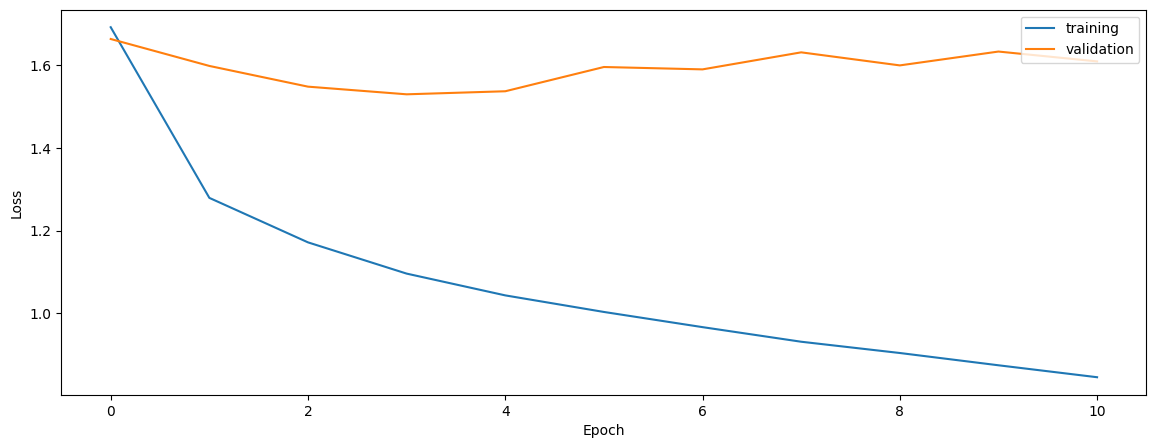

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5855397392597625
0.47664681240737244
0.5225441268606736


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.564765368283487
0.48526347824051314
0.530995528359614


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5814890710382513
0.5038535645472062
0.5587653343886031


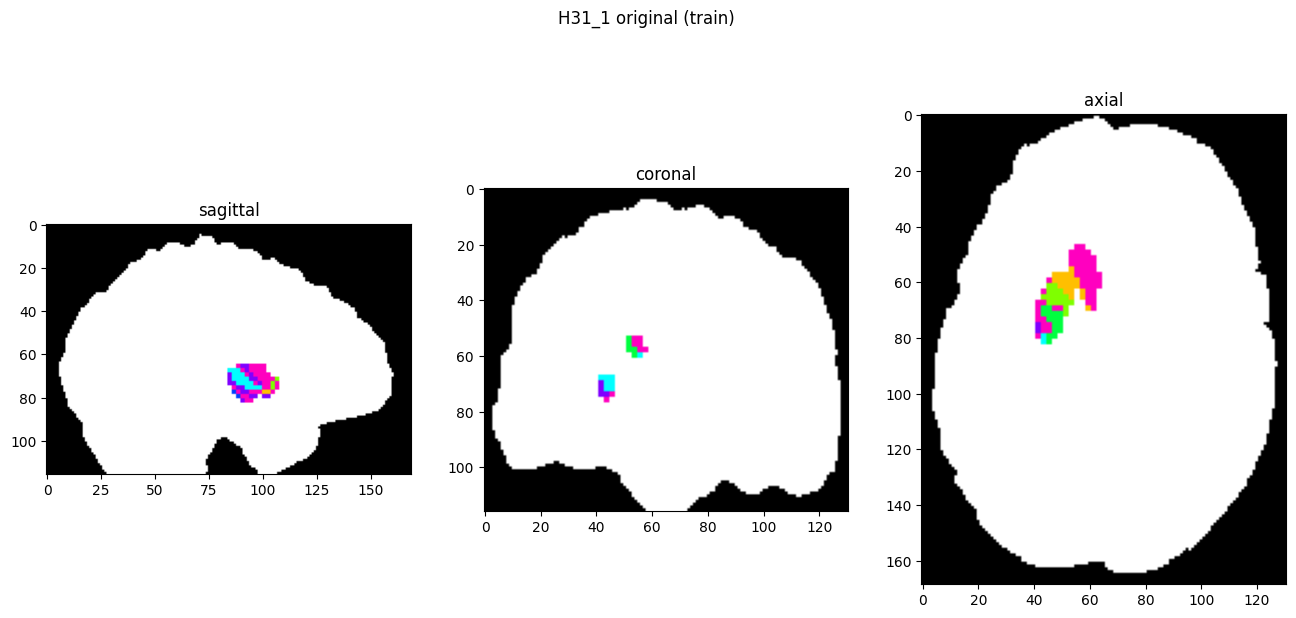

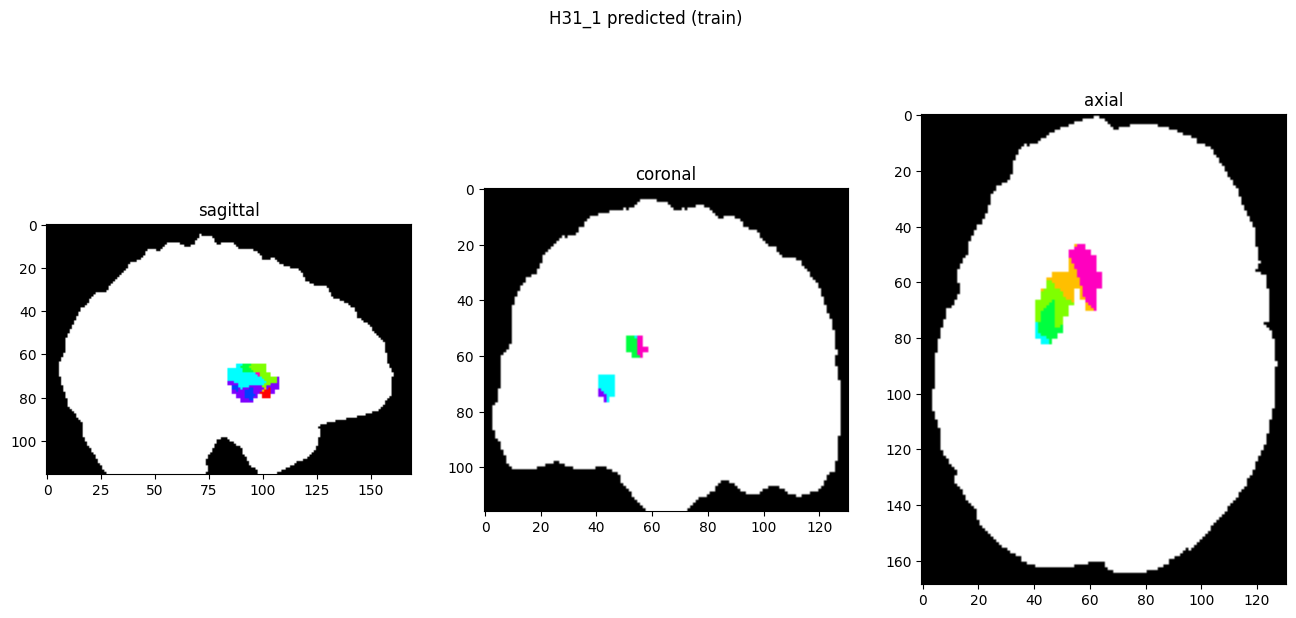

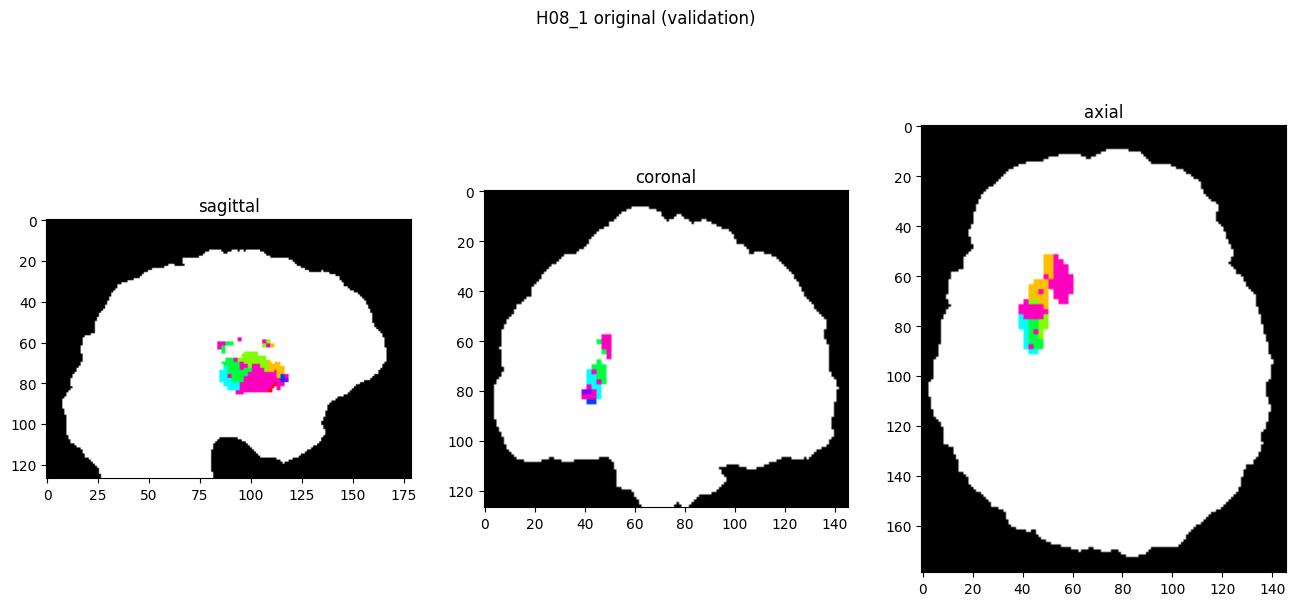

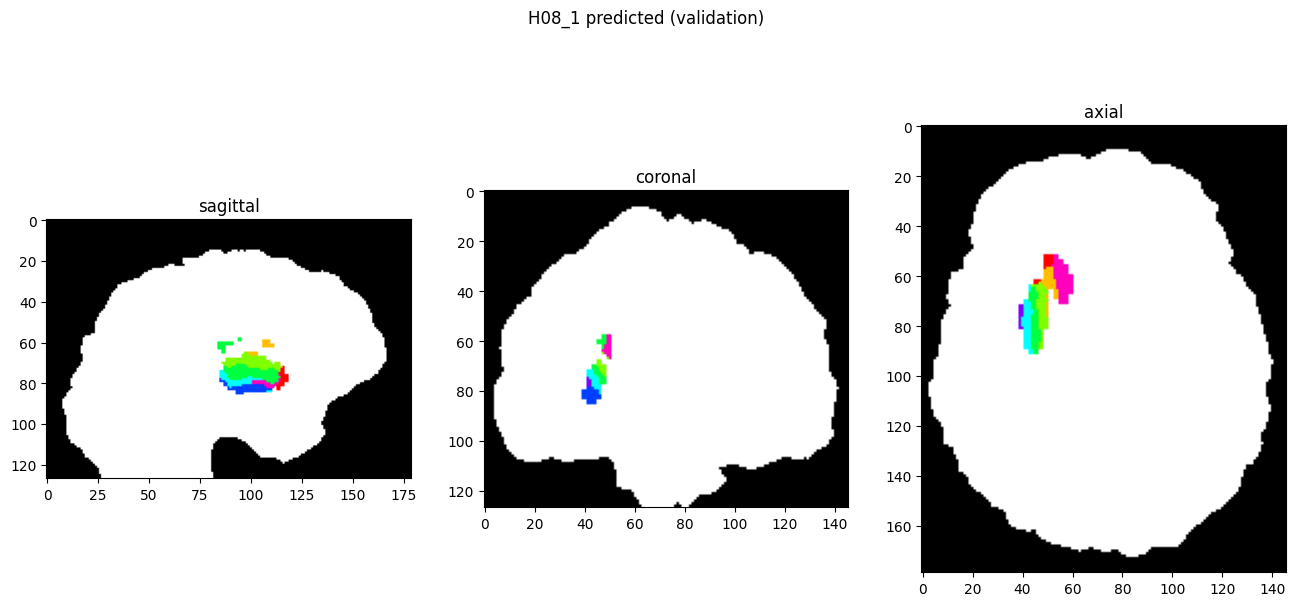

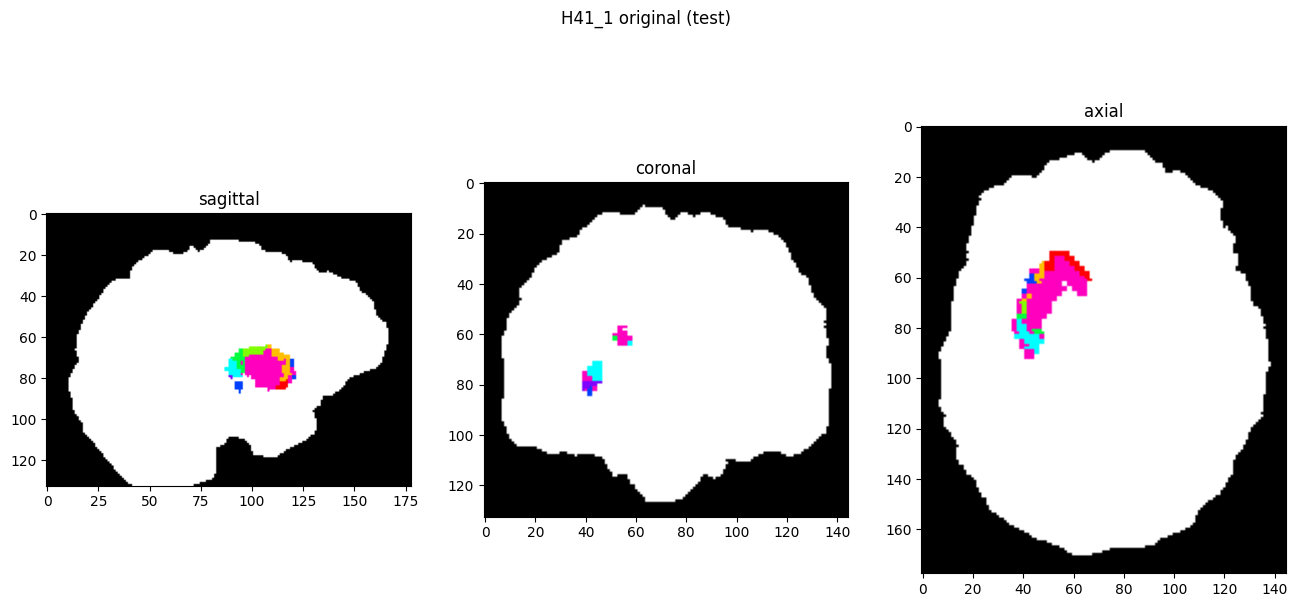

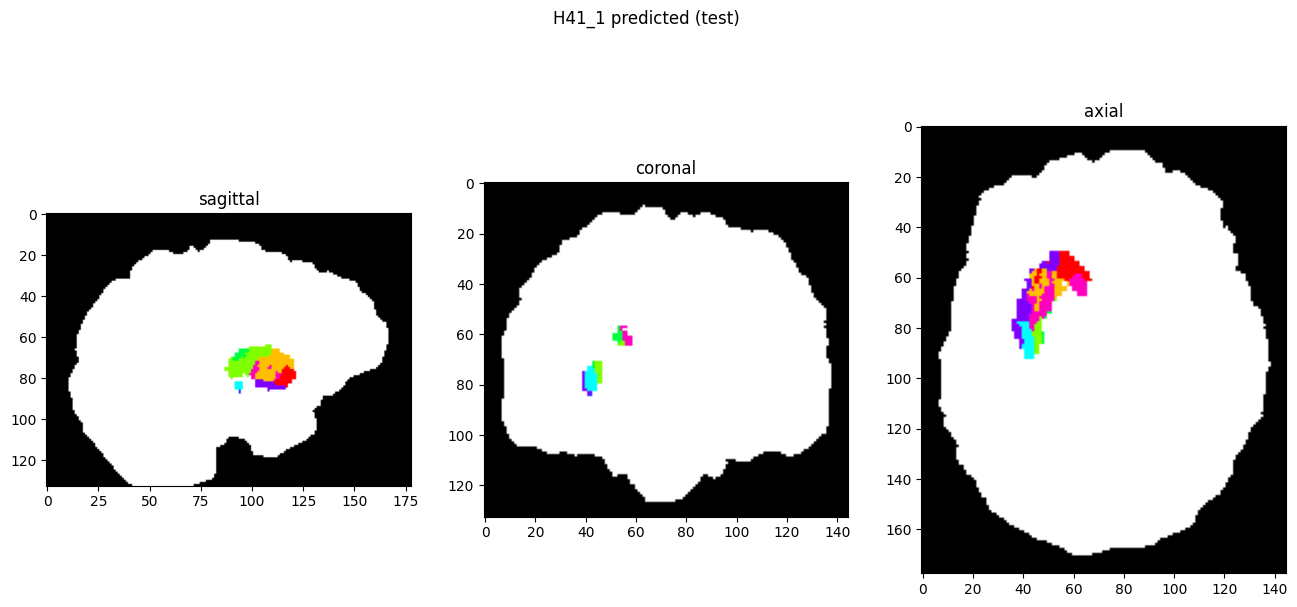

In [10]:
showResults(model, gen, threshold=0)